# Non-Negativ Matrix Factorization Model on 1-gram Tokens

In [1]:
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
from src.models.build_topic_model import show_topics, drop_topics, get_topic_patterns, sparse_argsort

C:\Users\poorj\Projects\CCC-Topic-Modeling\env\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Load dataset

In [2]:
path_to_data = Path('../data')
df = pd.read_csv(path_to_data / 'processed' /'tokenized_bigram_data.csv', converters={'tokenized_raw': eval, 'bigram_raw': eval, 'bigram_mults': eval})

### Fit model for cleaned token set (excl. extra stops)

In [5]:
tfidf = TfidfVectorizer(analyzer='word', tokenizer=lambda doc: doc, preprocessor = lambda doc: doc, token_pattern=None)
dtm_tfidf = tfidf.fit_transform(df['bigram_mults'])
vocab = np.array(tfidf.get_feature_names())

nmf_tfidf = NMF(init='random', n_components=6, max_iter=100, random_state = 0)
nmf_tfidf.fit(dtm_tfidf)

pyLDAvis.enable_notebook()
vis_nmf = pyLDAvis.sklearn.prepare(nmf_tfidf, dtm_tfidf, tfidf)
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.067964  0.035039       1        1  29.491300
1     -0.099945  0.131128       2        1  22.263619
5     -0.117905  0.160630       3        1  16.542376
3      0.206159 -0.111081       4        1  10.884520
0      0.258569  0.042817       5        1  10.854017
4     -0.178915 -0.258532       6        1   9.964169, topic_info=                        Term       Freq      Total Category  logprob  loglift
5688       (negyedéves, díj)  21.000000  21.000000  Default  30.0000  30.0000
8548       (állandó, lakcím)  18.000000  18.000000  Default  29.0000  29.0000
791    (beszedési, megbízás)  10.000000  10.000000  Default  28.0000  28.0000
1495        (dátum, állandó)  14.000000  14.000000  Default  27.0000  27.0000
1309  (csoportos, beszedési)   9.000000   9.000000  Default  26.0000  26.0000
...                      ...        ...        ...      ...      ...      ...
7541               (tud, ad)   1.230886   5.862912   Topic6  -6.1935   0.7453
6334     (rendez, szerződés)   1.152359   4.917427   Topic6  -6.2594   0.8552
5869        (név, születési)   1.184815   6.505337   Topic6  -6.2317   0.6031
7738            (tud, követ)   1.123226   4.421236   Topic6  -6.2850   0.9360
60           (ad, szerződés)   1.088810  12.444657   Topic6  -6.3162  -0.1300

[534 rows x 6 columns], token_table=      Topic      Freq                        Term
term                                             
52        2  0.186676                   (ad, név)
52        4  0.746704                   (ad, név)
52        6  0.186676                   (ad, név)
60        1  0.241067             (ad, szerződés)
60        2  0.160712             (ad, szerződés)
...     ...       ...                         ...
9272      1  0.810991         (ügyfél, azonosító)
9272      2  0.135165         (ügyfél, azonosító)
9283      2  1.438572          (ügyfél, kötelező)
9309      5  0.991355  (ügyfélprofil, kialakítás)
9338      5  1.024610              (ügynök, átad)

[543 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 4, 1, 5])

#### Show all topics

In [4]:
W1 = nmf_tfidf.fit_transform(dtm_tfidf)
H1 = nmf_tfidf.components_

show_topics(H1, num_top_words = 12, vocab = vocab)

['tud szerződés név információ meghatalmazás ért telefon biztosítás ad szerződő segít szám',
 'bank csoportos megbízás levon von beszedési levonás terhelés tud beszedés számla díj',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves összeg első kötelező nap',
 'levél kap küld biztosítás email hátralék néz cím értesítés ért türelem nap',
 'hozzájárul ajánlat adat elérhetőség akció megkeres szerződés álló ügynök kezelt általa személyes',
 'csekk befizet fizet küld kap negyedév tud negyedéves következő darab első csekken',
 'jelszó tud cím email felület online felhasználónév regisztráció mail küld belép kukac',
 'utal összeg közlemény lát számlaszám pénz utalás ír ügyfél számla kolléga tud']

* 0 - adatvédelmi okokból csak a szerződőnek info 
* 1 - csoportos beszedés nem működött  
* 2 - évfordulóval kapcsolatos díjváltozást nem érti
* 3 - levél vagy email a hátralékról (inter, díjfelszólító)
* 4 - marketing hozzájárulás
* 5 - csekkes befizetés probléma
* 6 - online irányba terelés
* 7 - egyedi utalásos probléma

#### Show main topic distribution

In [5]:
# Drop administrative topics 
W1_clean , H1_clean = drop_topics(W1, H1, drop_list = [0,4,6])

In [6]:
show_topics(H1_clean, num_top_words = 12, vocab = vocab)

['bank csoportos megbízás levon von beszedési levonás terhelés tud beszedés számla díj',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves összeg első kötelező nap',
 'levél kap küld biztosítás email hátralék néz cím értesítés ért türelem nap',
 'csekk befizet fizet küld kap negyedév tud negyedéves következő darab első csekken',
 'utal összeg közlemény lát számlaszám pénz utalás ír ügyfél számla kolléga tud']

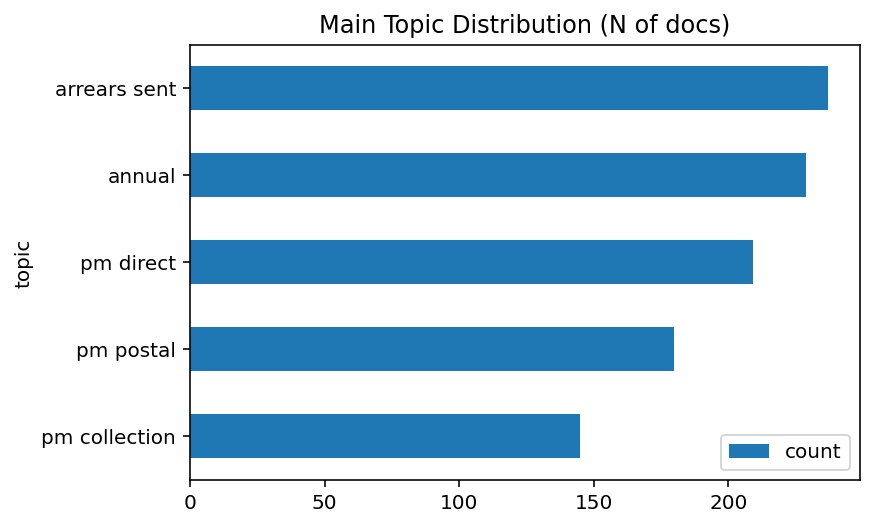

In [9]:
%config InlineBackend.figure_format = 'retina'

top_topic = pd.DataFrame(W1_clean.argmax(axis = 1), columns = ['count'])\
        .groupby(['count'])['count'].count().reset_index(drop = True)
top_topic = pd.DataFrame(top_topic)
top_topic['topic'] = ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct']
top_topic.set_index('topic', inplace = True)
top_topic.sort_values(by = ['count'], inplace = True)
top_topic.plot.barh(title = 'Main Topic Distribution (N of docs)');

#### Show multi-topic distribution

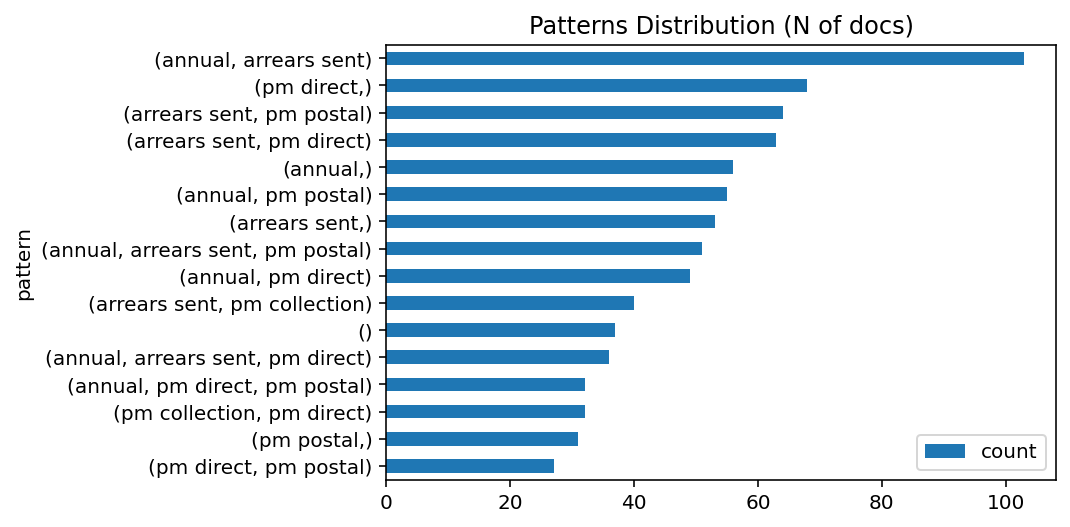

In [10]:
topic_patterns, pattern_by_doc = get_topic_patterns(W1_clean, ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                                    threshold = 0.015)
topic_patterns = topic_patterns.loc[0:15, ['pattern', 'count']]
topic_patterns.set_index('pattern', inplace = True)
topic_patterns.sort_values(by = ['count'], ascending = True).plot.barh(title = 'Patterns Distribution (N of docs)');

In [14]:
df_pattern = df.join(pattern_by_doc)
df_pattern.loc[:, ['file_name', 'text', 'pattern']].to_csv(path_to_data / 'processed' / '1gram_pattern_inspect.csv')

Megjegyzés: évforduló és háralék együttállást érdemes megnézni - lehet, hogy az évfordulót követő felszólítás generálja a legtöbb hívást

### Fit model for main topic

In [87]:
# Subset for main topic
MAIN_TOPIC_ID = 4
NUM_OF_TOPICS = 3

main_topic = pd.DataFrame(W1_clean.argmax(axis = 1), columns = ['main_topic'])
df_subset = df.join(main_topic)
df_subset = df_subset.loc[df_subset['main_topic'] == MAIN_TOPIC_ID, :]

# Fit NMF
dtm_tfidf_subset = tfidf.fit_transform(df_subset['tokenized_mults_extr'])
vocab_subset = np.array(tfidf.get_feature_names())

nmf_tfidf_subset = NMF(init='random', n_components=NUM_OF_TOPICS, max_iter=100, random_state = 0)
nmf_tfidf_subset.fit(dtm_tfidf_subset)

pyLDAvis.enable_notebook()
vis_nmf_subset = pyLDAvis.sklearn.prepare(nmf_tfidf_subset, dtm_tfidf_subset, tfidf)
vis_nmf_subset

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.071068  0.144939       1        1  45.503750
1     -0.153874 -0.113257       2        1  42.815916
0      0.224942 -0.031682       3        1  11.680334, topic_info=             Term      Freq      Total Category  logprob  loglift
1178   hozzájárul  4.000000   4.000000  Default  30.0000  30.0000
20           adat  4.000000   4.000000  Default  29.0000  29.0000
3411       ügyfél  7.000000   7.000000  Default  28.0000  28.0000
53        ajánlat  3.000000   3.000000  Default  27.0000  27.0000
666   elérhetőség  3.000000   3.000000  Default  26.0000  26.0000
...           ...       ...        ...      ...      ...      ...
2225          nap  1.182544   9.476260   Topic3  -5.1716   0.0661
1890          lát  1.030466  10.329204   Topic3  -5.3093  -0.1577
2888          tud  1.103160  22.394770   Topic3  -5.2411  -0.8634
263         belép  0.869424   2.426121   Topic3  -5.4792   1.1210
3003         utal  0.938469  11.237610   Topic3  -5.4028  -0.3355

[306 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
18        1  0.586649                ad
18        2  0.293324                ad
18        3  0.146662                ad
20        1  0.432281              adat
20        3  0.648421              adat
...     ...       ...               ...
3371      2  0.484062            összeg
3411      2  0.978466            ügyfél
3413      3  1.140993      ügyfélprofil
3415      1  1.981678  ügyfélszolgálati
3419      3  0.671601            ügynök

[227 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])